In [157]:
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import netCDF4
from meteostat import Stations
import os

nearest_station = []
df_final = pd.DataFrame()
    
for file in os.listdir( 'P:\\Trees'):
    filename = os.fsdecode(file)
    if filename.startswith('rainfall_hadukgrid_uk_60km_ann_'):

        path = f'P:\\Trees\\{filename}'
        nc = netCDF4.Dataset(path)

        # nc.variables.keys()

        #=======================
        # Extract relevant attributes from nc file

        rainfall_data = nc.variables['rainfall'][:]
        rainfall_data = rainfall_data.data.flatten()
        latitude_data = nc.variables['latitude'][:]
        latitude_data = latitude_data.filled(np.nan).flatten()
        longitude_data = nc.variables['longitude'][:]
        longitude_data = longitude_data.filled(np.nan).flatten()

        #========================
        # Convert time to human readable timestamp
        time = nc.variables['time']
        time_data = nc.variables['time'][:]
        base_time = time.units.split('since')[-1].strip()
        base_time = datetime.strptime(base_time, '%Y-%m-%d %H:%M:%S')
        date = base_time + timedelta(hours=float(time_data.filled(np.nan).flatten()[0]))

        #=======================
        # Enrich with nearest station data
        stations = Stations()
        stattions = stations.region('UK')

        for x, y in zip(longitude, latitude):
            station = stations.nearby(y,x)
            station = station.fetch(1)
            station = station['name'][0].split('/')[0].strip()
            
            if len(station) != 0:
                nearest_station.append(station['name'][0].split('/')[0].strip())
            else:
                nearest_station.append('Null')

        print(len(latitude_data), len(longitude_data), len(rainfall_data), len(nearest_station))


        rdict = {'latitude':latitude_data, 'longitude':longitude_data, 'rainfall':rainfall_data, 'nearest_station':nearest_station}
        df = pd.DataFrame(rdict)
        df['date'] = date

        df_final = pd.concat([df_final, df])

391 391 391 0


ValueError: All arrays must be of the same length

In [154]:
df_final

,latitude,longitude,rainfall,date
0,48.789596,-10.309652,1.000000e+20,2020-07-01
1,48.845471,-9.500016,1.000000e+20,2020-07-01
2,48.895685,-8.688010,1.000000e+20,2020-07-01
3,48.940200,-7.873882,1.000000e+20,2020-07-01
4,48.978981,-7.057882,1.000000e+20,2020-07-01
...,...,...,...,...
386,60.937895,0.030265,1.000000e+20,2023-07-01
387,60.916673,1.136076,1.000000e+20,2023-07-01
388,60.886393,2.239828,1.000000e+20,2023-07-01
389,60.847093,3.340807,1.000000e+20,2023-07-01


In [84]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as ec

#=========================
# Load Driver
driver = webdriver.Chrome()
url = 'http://www.forestdss.org.uk/geoforestdss'
driver.get(url)

#=========================
# Locate search bar and enter Grid Ref.
search_bar = driver.find_element(By.ID, 'gridref')
search_bar.clear()
search_bar.send_keys("NT090950")
go = driver.find_element(By.XPATH, "//input[@value='Go']")
go.click()

#=========================
# Download CSV from results
download = WebDriverWait(driver, 10).until(
    ec.presence_of_element_located((By.XPATH, "//a[contains(@href, 'EscModelServlet')]"))
)
download.click()


In [82]:
def generate_grid_ref(grid_squares):

    import random

    references = set()
    
    for grid_square in grid_squares:

        easting = random.randint(0,99)
        northing = random.randint(0,99)
        easting_str = f'{easting:03d}'
        northing_str = f'{northing:03d}'
        grid_ref = f"{grid_square}{easting_str}{northing_str}"

        references.add(grid_ref)

    return list(references)



In [95]:
grid_squares = ['SP', 'SO', 'SK']
generate_grid_ref(grid_squares)

['SP070030', 'SO049075', 'SK004068']

In [114]:
from openpyxl import Workbook
import pandas as pd
import csv

wb = Workbook()
ws = wb.active
with open('P:\ESC_NT090950.csv', 'r') as f:
    for row in csv.reader(f):
        ws.append(row)
wb.save('P:\ESC_NT090950_TEST.xlsx')

at = int(pd.read_excel('P:\ESC_NT090950_TEST.xlsx').iloc[9][1])
print(f'Accumulated Temperature: {at}')



Accumulated Temperature: 1096


In [5]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.select import Select

#=========================
# Load Driver
driver = webdriver.Chrome()
url = 'http://www.forestdss.org.uk/geoforestdss'
driver.get(url)

#=========================
# Change drop down option to 'Download ESC Site Data'
select = Select(driver.find_element(By.ID, 'select_tool'))
select.select_by_visible_text('Download ESC Site Data')

#=========================
# Upload file template and download results
form = driver.find_element(By.ID, 'esc-data')
file_input = form.find_element(By.ID, 'esc-file')
file_input.send_keys('/Users/dougaltoms/Downloads/esc-data-test-species.csv')
form.submit()

#=========================
# Read in results
df = pd.read_csv('/Users/dougaltoms/Downloads/esc_data.csv')
df.head()

,x,y,at,ct,dams,md,smr,snr,elevation,species,yc,cyc,limitingfact,ecosuit,nvc1,nvc2,nvc3
0,309000.0,695000.0,1096,6,16,84,4.0,4.0,255,SS,20,20,DAMS,0.83,W9,W6,W11
1,304620.0,692858.0,1157,5,13,94,4.0,3.0,212,SOK,5,6,SMR,0.78,W11,W17,W7
2,312266.0,696082.0,1145,6,13,94,6.0,3.0,218,SP,13,13,DAMS,0.92,W11,W17,W10


In [19]:
def convert_eastings_northing_to_lat_lon(df):

    import requests
    import pandas as pd
    import json

    requests.packages.urllib3.disable_warnings()

    lat = []
    lon = []

    for index, row in df.iterrows():
        easting = row['x']
        northing = row['y']

        url = fr'https://webapps.bgs.ac.uk/data/webservices/CoordConvert_LL_BNG.cfc?method=BNGtoLatLng&easting={easting}&northing={northing}'
        r = requests.get(url, verify=False)
        j = json.loads(r.content.decode('utf-8'))

        lon.append(j['LONGITUDE'])
        lat.append(j['LATITUDE'])

    df['latitude'] = lat
    df['longitude'] = lon

    return df

In [20]:
convert_eastings_northing_to_lat_lon(df)

,x,y,at,ct,dams,md,smr,snr,elevation,species,yc,cyc,limitingfact,ecosuit,nvc1,nvc2,nvc3,latitude,longitude
0,309000.0,695000.0,1096,6,16,84,4.0,4.0,255,SS,20,20,DAMS,0.83,W9,W6,W11,56.138998,-3.465949
1,304620.0,692858.0,1157,5,13,94,4.0,3.0,212,SOK,5,6,SMR,0.78,W11,W17,W7,56.118904,-3.535636
2,312266.0,696082.0,1145,6,13,94,6.0,3.0,218,SP,13,13,DAMS,0.92,W11,W17,W10,56.149329,-3.413768


In [60]:
import random
import pandas as pd

df = pd.DataFrame({'x':[], 'y':[], 'species':[]})
bbox = ((9.184570,49.837982),(2.329102,59.489726)) # UK lat/lon
bbox = ((116315, 17883),(645170, 1075060)) # UK easting/northing

trees = ['SS', 'SOK', 'SP']

x = []
y = []
species = []

for i in range(1,100):
    easting = random.randint(bbox[0][0], bbox[1][0])
    northing = random.randint(bbox[0][1], bbox[1][1])
    x.append(easting)
    y.append(northing)
    species.append(random.choice(trees))

df['x'] = x
df['y'] = y
df['species'] = species
df.head(10)

df.to_csv('/Users/dougaltoms/Downloads/esc_dougal_test.csv')


In [61]:
df = df.set_index('x')
df.to_csv('/Users/dougaltoms/Downloads/esc_dougal_test.csv')

In [62]:
df = pd.read_csv('/Users/dougaltoms/Downloads/esc_data (3).csv')

In [68]:
df = df[df['elevation']!= -9999]
convert_eastings_northing_to_lat_lon(df)

,x,y,at,ct,dams,md,smr,snr,elevation,species,yc,cyc,limitingfact,ecosuit,nvc1,nvc2,nvc3,latitude,longitude
1,435151.0,288821.0,1673,11,13,173,3.0,3.0,99,SP,9.0,13.0,SMR,0.63,W4,W7,W1,52.496170,-1.483671
6,262226.0,875064.0,994,4,14,70,6.0,1.0,231,SP,6.0,10.0,SNR,0.52,W18,W17,W19,57.744086,-4.316219
7,457718.0,366909.0,1625,10,12,177,5.0,3.0,83,SP,14.0,14.0,DAMS,0.97,W11,W15,W10,53.196139,-1.137507
10,226906.0,813033.0,1176,5,12,94,7.0,1.0,126,SS,4.0,25.0,SMR,0.16,W16,W17,W18,57.175366,-4.864907
11,454868.0,289364.0,1631,11,13,171,3.0,3.0,120,SS,18.0,18.0,MD,0.63,W4,W7,W1,52.499428,-1.193185
12,315171.0,967081.0,1112,4,16,124,3.0,3.0,42,SP,9.0,10.0,SMR,0.63,W4,W7,W1,58.583417,-3.460670
15,219649.0,759476.0,969,4,15,44,2.0,1.0,325,SP,4.0,9.0,SMR,0.30,W4,W20,-,56.692096,-4.946610
19,494345.0,168996.0,1876,10,10,204,5.0,5.0,50,SP,13.0,13.0,SNR,0.91,W8,W12,W13,51.412146,-0.644819
21,138814.0,802382.0,1139,3,19,65,2.0,1.0,173,SOK,1.0,1.0,SMR,0.14,W4,-,-,57.038306,-6.307089
22,265375.0,865560.0,1269,4,10,131,8.0,1.0,0,SS,0.0,23.0,SMR,0.00,-,-,-,57.659741,-4.258047


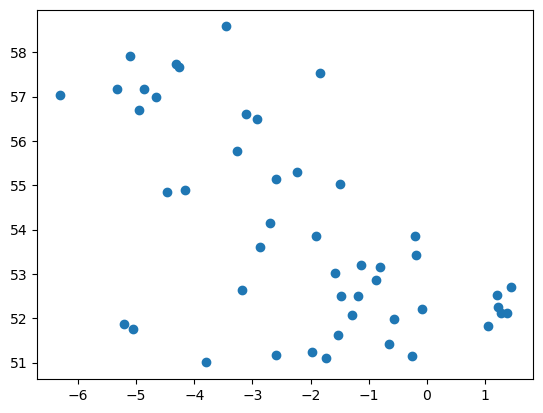

In [70]:
import matplotlib.pyplot as plt

plt.scatter(x=df['longitude'], y=df['latitude'])
plt.show()